-----------------------------------------------------
# Tech Challenge (Fase 1): 📓 Análise de Câncer de Pele
-----------------------------------------------------
Aluno: RM-366142 [Fernando Stuque Alves]

---

# Tech Challenge: 🔬 Análise e Modelagem para Diagnóstico de Câncer de Pele


## Visão Geral

Este notebook foca na análise e modelagem preditiva utilizando os metadados tabulares do dataset HAM10000. O processo está dividido em duas fases principais, detalhadas abaixo.

### Fase 1: Análise Exploratória de Dados (EDA)
O objetivo desta fase é extrair insights e identificar padrões nos dados brutos.

*   **Análise Demográfica:** Distribuição de idade e gênero dos pacientes.
*   **Análise Clínica:**
    *   Distribuição dos 7 tipos de lesões (classes).
    *   Investigação do desbalanceamento de classes.
    *   Distribuição da localização anatômica das lesões.
*   **Análise de Correlação:** Investigação das relações lineares entre as variáveis.

### Fase 2: Modelagem Preditiva
O objetivo é construir um classificador binário para identificar Melanoma vs. Não-Melanoma.

*   **Benchmark de Modelos:** Avaliação sistemática de múltiplos algoritmos (Logistic Regression, Random Forest, XGBoost) via validação cruzada.
*   **Seleção de Métrica:** Foco em `Recall` e `F1-Score` devido ao desbalanceamento de classes.
*   **Otimização de Hiperparâmetros:** Uso de `GridSearchCV` para refinar o modelo com melhor desempenho.
*   **Avaliação Final:** Análise da performance do modelo campeão no conjunto de teste.
*   **Interpretabilidade:** Uso da biblioteca SHAP para explicar as predições do modelo final.


In [ ]:
# Importando dependências
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from PIL import Image
import glob
import os
import sys
from google.colab import drive
from plotly.subplots import make_subplots
import plotly.graph_objects as go

**Montando o ambiente**

In [ ]:
# 1. Montar o Google Drive
drive.mount('/content/drive')

# 2. Definir o caminho raiz do projeto
# ❗ É necessário ser o mesmo caminho que você usou no notebook '01_Setup_e_Processamento'
PROJECT_PATH = '/content/drive/MyDrive/Colab Notebooks/Tech Challenge/skin_cancer_analysis'

# 3. Mudar o diretório de trabalho para a raiz do projeto
os.chdir(PROJECT_PATH)

# 4. Adicionar o diretório raiz ao path do Python
if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)

# ❗ Verifique se o diretório de trabalho atual está correto antes de executar todas as outras células
print(f"Diretório de trabalho atual: {os.getcwd()}")
print("Caminho do projeto adicionado ao sys.path. Agora você pode importar módulos de 'src'.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Diretório de trabalho atual: /content/drive/MyDrive/Colab Notebooks/Tech Challenge/skin_cancer_analysis
Caminho do projeto adicionado ao sys.path. Agora você pode importar módulos de 'src'.


## 1. Explorando nossos dados originais

**Nosso Objetivo nesta Análise:**
1.  **Entender o Perfil dos Pacientes:** Quem são as pessoas nos nossos dados? (Idade, gênero)
2.  **Mapear as Lesões:** Quais são os tipos de lesões? Existe alguma mais comum? Onde elas aparecem?
3.  **Identificar Desafios Técnicos:** Há problemas nos dados que precisamos resolver antes da modelagem (dados faltantes, desbalanceamento)?
4.  **Formular Hipóteses:** Podemos encontrar relações entre os dados que nos ajudem a construir um modelo preditivo?

Vamos começar nossa investigação.

In [ ]:
# Carregando os dados de metadados originais
import pandas as pd

METADATA_PATH = 'data/HAM10000_metadata.csv'
df_original = pd.read_csv(METADATA_PATH)

In [ ]:
print("Visão geral dos dados brutos:")
df_original.head()

Visão geral dos dados brutos:


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
# Estrutura do nossos dados tabulares
df_original.shape

(10015, 7)

In [ ]:
# Verificando valores ausentes
print("Contagem de valores nulos por coluna:")
print(df_original.isnull().sum())

Contagem de valores nulos por coluna:
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64


Nossa primeira verificação revela um ponto de atenção imediato: a coluna `age` (idade) possui 57 valores ausentes. Isso é comum em dados médicos. No nosso script de pré-processamento, já decidimos tratar isso preenchendo com a mediana, uma escolha robusta que evita a influência de idades muito altas ou baixas.

### 1.1. A Distribuição das Classes de Lesões

**Qual é o nosso principal desafio? A Distribuição das Lesões**

Nossa primeira e mais importante investigação é entender a distribuição da nossa variável alvo: o tipo de lesão de pele (`dx`). Isso nos dirá qual o tamanho do desafio que enfrentamos, especialmente em relação ao desbalanceamento de classes. Um desequilíbrio severo pode fazer com que o modelo ignore as classes raras, que são muitas vezes as mais importantes clinicamente (como o Melanoma).

In [ ]:
print('[Classes de dx]\n')
for i in df_original['dx'].unique():
  print(f'{i}')

[Classes de dx]

bkl
nv
df
mel
vasc
bcc
akiec


In [ ]:
# Para uma melhor exploração das classes de lesões, vamos mapear as abreviações para nomes completos na nossa variável alvo.
lesion_type_dict = {
    'nv': 'Nevos Melanocíticos',
    'mel': 'Melanoma',
    'bkl': 'Queratose Benigna',
    'bcc': 'Carcinoma Basocelular',
    'akiec': 'Queratoses Actínicas',
    'vasc': 'Lesões Vasculares',
    'df': 'Dermatofibroma'
}

df_original['dx_full'] = df_original['dx'].map(lesion_type_dict)

display(df_original.head(4))

,lesion_id,image_id,dx,dx_type,age,sex,localization,dx_full
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Queratose Benigna
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Queratose Benigna
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Queratose Benigna
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Queratose Benigna


In [ ]:
# Contando as ocorrências e ordenando para melhor visualização
class_counts = df_original['dx_full'].value_counts()

fig = px.bar(x=class_counts.index,
             y=class_counts.values,
             title='Distribuição das Classes de Lesões de Pele',
             labels={'x': 'Tipo de Lesão', 'y': 'Quantidade'},
             text=class_counts.values,
             color=class_counts.index)

fig.update_layout(xaxis_title="Tipo de Lesão", yaxis_title="Contagem", title_x=0.5)
fig.show()

In [ ]:
# Distribuição percentual das categorias
class_distribution = df_original['dx_full'].value_counts()
class_percentage = df_original['dx_full'].value_counts(normalize=True) * 100

class_overview = pd.DataFrame({
    'Contagem': class_distribution,
    'Percentual (%)': class_percentage
})

print("\nContagem e Percentual por Tipo de Lesão:")
class_overview


Contagem e Percentual por Tipo de Lesão:


,Contagem,Percentual (%)
dx_full,,
Nevos Melanocíticos,6705,66.949576
Melanoma,1113,11.113330
Queratose Benigna,1099,10.973540
Carcinoma Basocelular,514,5.132302
Queratoses Actínicas,327,3.265102
Lesões Vasculares,142,1.417873
Dermatofibroma,115,1.148278


### **A Descoberta Crítica:**

O gráfico interativo acima revela nosso **maior desafio técnico e clínico: um severo desbalanceamento de classes.**

*   **A Grande Maioria:** Mais de 6.000 casos (67%) são "Nevos Melanocíticos" (`nv`), que são majoritariamente benignos.
*   **O Caso Crítico:** O **Melanoma (`mel`)**, o tipo mais perigoso de câncer de pele, representa pouco mais de 1.100 casos (11%).
*   **Ponto de Atenção:** Se não tratarmos isso, o nosso modelo pode se tornar "viciado" e aprender a simplesmente chutar "Nevo", alcançando uma alta acurácia, mas falhando em detectar os casos de Melanoma, o que seria clinicamente inútil e perigoso.

**Decisão Estratégica:** Esta descoberta guiará toda a nossa modelagem. Precisamos usar técnicas de balanceamento como **amostragem estratificada** na divisão dos dados e focar em métricas como **Recall** e **F1-Score**.

### 1.2. Relação da Idade com o Tipo de Lesão

Agora, vamos ver como as outras variáveis (idade, sexo, localização) se relacionam com a nossa variável alvo.

A começarmos pela idade, que é um fator de risco conhecido para muitas doenças de pele. Vamos investigar se certos tipos de lesão são mais prevalentes em faixas etárias específicas.

In [ ]:
# Distribuição para a idade e para gênero
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'histogram'}, {'type': 'pie'}]],
    subplot_titles=('<b>Distribuição de Idade dos Pacientes</b>', '<b>Distribuição por Gênero</b>')
)

# Gráfico de Histograma para Idade
fig.add_trace(
    go.Histogram(x=df_original['age'], nbinsx=30, name='Idade', marker_color='#330C73'),
    row=1, col=1
)

# Gráfico de Pizza para Gênero
gender_counts = df_original['sex'].value_counts()
fig.add_trace(
    go.Pie(labels=gender_counts.index, values=gender_counts.values, name='Gênero', hole=.3),
    row=1, col=2
)

fig.update_layout(
    title_text='<b>Perfil Demográfico dos Pacientes</b>',
    title_x=0.5,
    showlegend=False,
    height=500
)
fig.show()

Nossa análise demográfica mostra que o dataset é bem distribuído entre homens (54%) e mulheres (45.5%). A faixa etária mais comum, como pode ser explorado no histograma, está entre 30 e 60 anos. A presença de idade desconhecida "unknown" no gênero e a ausência de idade em alguns registros reforçam a necessidade de um pré-processamento cuidadoso.

In [ ]:
fig = px.box(df_original,
             x='dx_full',
             y='age',
             title='Distribuição de Idade por Tipo de Lesão',
             labels={'dx_full': 'Tipo de Lesão', 'age': 'Idade'},
             color='dx_full')

fig.update_layout(title_x=0.5)
fig.show()

Claramente, a idade não se distribui de forma uniforme. Lesões como Queratose Benigna (bkl) e Carcinoma Basocelular (bcc) tendem a aparecer em pacientes mais velhos, o que é clinicamente esperado. O Melanoma (mel) também apresenta uma mediana de idade mais elevada.


A idade é uma feature preditiva muito forte! Será que o modelo  aprenderá a usar essa informação?

Veremos mais para frente na etapa de treinamento e teste.

### 1.3. Análise por Localização da Lesão e Sexo

- Onde as lesões aparecem no corpo?

- Existe alguma diferença entre os sexos?

- Essas informações podem nos dar pistas sobre as causas (ex: exposição solar).

In [ ]:
# Gráfico de barras para localização da lesão
fig_loc = px.bar(df_original['localization'].value_counts(),
                 title='Distribuição de Lesões por Localização no Corpo',
                 labels={'index': 'Localização', 'value': 'Quantidade'})
fig_loc.update_layout(title_x=0.5)
fig_loc.show()

A maioria das lesões registradas está nas costas (`back`), tronco (`trunk`) e extremidades (`lower/upper extremity`). A categoria "rosto" (`face`) também é significativa. Essa informação pode ser útil para o modelo, pois certas lesões têm predileção por áreas mais expostas ao sol. A interatividade permite ver os números exatos para cada parte do corpo.

In [ ]:
# Idade, Sexo e o Risco Combinados

# Vamos remover os casos onde o sexo é 'unknown' (desconhecido) para ter uma visualização mais limpa
df_plot = df_original[df_original['sex'] != 'unknown'].copy()

fig = px.violin(
    df_plot,
    x='dx_full',
    y='age',
    color='sex',
    box=True,
    points="all",
    hover_data=['localization'],
    title='Distribuição da Idade por Tipo de Lesão e Sexo',
    labels={'dx_full': 'Tipo de Lesão', 'age': 'Idade do Paciente', 'sex': 'Sexo'},
    color_discrete_map={'male': 'dodgerblue', 'female': 'hotpink'}
)

fig.update_xaxes(tickangle=45)
fig.show()

A primeira e mais óbvia conclusão é que a idade do paciente é uma variável extremamente poderosa para diferenciar os tipos de lesão. As distribuições de idade não são aleatórias, elas formam padrões claros. Um médico experiente já sabe disso intuitivamente, mas agora nós provamos com dados. Isso nos diz que a feature `age` será vital para o sucesso do nosso modelo de Machine Learning.

**As Lesões da Idade Avançada:**

Olhando para a direita do gráfico: Queratose Benigna, Carcinoma Basocelular e Queratoses Actínicas têm seus "violinos" e a maioria dos seus pontos de dados concentrados na parte superior do gráfico.

Nossos dados mostram um padrão claro: certas lesões são predominantemente condições de envelhecimento. Carcinoma Basocelular e Queratoses (Benigna e Actínica) são muito mais prevalentes em pacientes com mais de 60 anos. A mediana de idade para esses casos está consistentemente acima dos 65-70 anos. Isso reforça a hipótese de que o dano solar acumulado ao longo da vida é um fator de risco significativo, e nosso modelo deve aprender a dar um peso maior a essas suspeitas em pacientes mais velhos.


**A Lesão da Juventude e Meia-Idade:**

O Nevo Melanocítico (pintas/sinais comuns) tem uma distribuição de idade muito mais baixa. O "violino" é mais largo e centrado entre 30 e 50 anos.

Em forte contraste, os Nevos Melanocíticos, que são a classe mais comum em nosso dataset, são típicos de uma população mais jovem. A idade mediana gira em torno dos 40-45 anos. Isso é clinicamente esperado, já que a maioria das pintas surge durante a infância e a vida adulta jovem. Para a nossa exploração, isso significa que uma lesão em um paciente de 25 anos tem uma probabilidade a priori muito maior de ser um Nevo do que um Carcinoma.


**Melanoma vs. Nevos:**


Agora, olhando para o Melanoma. Sua distribuição de idade está em um ponto intermediário crítico. É mais alta que a dos Nevos, mas não tão alta quanto a dos Carcinomas. A mediana de idade para o Melanoma parece estar na faixa dos 50 anos, e a dispersão é grande.

Aqui está a descoberta mais valiosa para a nossa investigação. O Melanoma, o diagnóstico mais perigoso, vive em uma zona de sobreposição. Embora possa ocorrer em qualquer idade, sua distribuição etária é visivelmente mais velha que a dos Nevos comuns, mas mais jovem que a dos outros cânceres de pele. Um sinal em um paciente de 55 anos possa ser estatisticamente mais suspeito de ser um Melanoma do que um sinal semelhante em um paciente de 35. Esta separação, mesmo que sutil, é uma pista importante para o nosso modelo. Ele precisará aprender essa nuance para distinguir efetivamente uma pinta benigna de um melanoma potencialmente perigoso.


**Diferenças entre Gêneros:**


Em geral, as distribuições entre homens (azul) e mulheres (rosa) são bastante semelhantes para a maioria das lesões. Não há uma diferença drástica. No entanto, podemos notar sutilezas. Por exemplo, para Melanoma e Carcinoma Basocelular, a mediana de idade para os homens parece ser ligeiramente mais alta do que para as mulheres.

Quando segmentamos por gênero, a idade continua sendo o fator dominante. As diferenças entre homens e mulheres são sutis. No entanto, para os diagnósticos mais graves como Melanoma e Carcinoma Basocelular, notamos que a mediana de idade nos homens é ligeiramente superior à das mulheres em nosso dataset. Embora seja uma diferença pequena, nosso modelo pode usar essa informação combinada com outras features para refinar suas predições.

### 1.4. Visualizando as Imagens das Lesões

Até agora, analisamos os metadados. Mas o coração deste problema é a imagem. Vamos visualizar exemplos de cada classe para ter uma intuição visual do problema.

**Será que as classes são facilmente distinguíveis a olho nu?**

In [ ]:
# Criando um dicionário que mapeia cada image_id ao seu caminho completo (queremos relacionar os dois datasets)
image_paths = {os.path.splitext(os.path.basename(x))[0]: x
               for x in glob.glob(os.path.join('data', '*', '*.jpg'))}

df_original['path'] = df_original['image_id'].map(image_paths)

# Vamos visualizar uma amostra de cada tipo de lesão
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize=(4 * n_samples, 3 * 7))

for n_axs, (type_name, type_rows) in zip(m_axs, df_original.sort_values(['dx_full']).groupby('dx_full')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        img = Image.open(c_row['path'])
        c_ax.imshow(img)
        c_ax.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Como podemos ver através dos exemplos, as imagens acima revelam a dificuldade da classificação. Muitas lesões de Melanoma e Nevos são visualmente muito semelhantes para um olho não treinado. Algumas classes, como Lesões Vasculares, têm uma aparência mais distinta.

Isso reforça a necessidade de um modelo de CNN sofisticado, provavelmente pré-treinado (Transfer Learning), que seja capaz de capturar texturas sutis, gradientes de cor e padrões de borda que um humano leigo não consegue.

### 1.5. Pré-processamento e Modelagem

Utilizando a função que irá carregar, limpar, transformar os dados e retornar o resultado.

O notebook **01_Setup_e_Preprocessamento** previamente carregado, possui uma função que faz o download dos dataset (metadados e imagens), cria a estrutura das pastas, carrega e trata os dados para pré-processarmos nosso modelo de classificação.

Nesta etapa, se tudo estiver correto, será possível carregar um data frame tratado e "*encodado*".

In [ ]:
# Importando o módulo de Setup e Pré-processamento dos dados (dp = data preprocessing)
import src.data_preprocessing as dp

# Utilizando a função dentro do 'src/data_preprocessing.py'
print("Iniciando o pré-processamento dos dados...")
df_preprocess = dp.preprocess_tabular_data(METADATA_PATH)

print("\n--- Visualização do DataFrame Pré-processado no Notebook de Análise ---")
display(df_preprocess.head())

Iniciando o pré-processamento dos dados...
Carregando dados de: data/HAM10000_metadata.csv
Valores nulos em 'age' preenchidos com a mediana (50.0).
Aplicando One-Hot Encoding em: ['dx_type', 'sex', 'localization']
Aplicando StandardScaler na coluna 'age'.
Limpando os nomes das colunas...
Nomes das colunas padronizados.

Pré-processamento concluído com sucesso!

--- Visualização do DataFrame Pré-processado no Notebook de Análise ---


/content/drive/MyDrive/Colab Notebooks/Tech Challenge/skin_cancer_analysis/src/data_preprocessing.py:22: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,lesion_id,image_id,dx,age,dx_type_confocal,dx_type_consensus,dx_type_follow_up,dx_type_histo,sex_female,sex_male,...,localization_face,localization_foot,localization_genital,localization_hand,localization_lower_extremity,localization_neck,localization_scalp,localization_trunk,localization_unknown,localization_upper_extremity
0,HAM_0000118,ISIC_0027419,bkl,1.663522,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,HAM_0000118,ISIC_0025030,bkl,1.663522,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,HAM_0002730,ISIC_0026769,bkl,1.663522,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,HAM_0002730,ISIC_0025661,bkl,1.663522,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,HAM_0001466,ISIC_0031633,bkl,1.368014,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Criando a variável alvo binária: Melanoma vs. Não-Melanoma
df_preprocess['target_melanoma'] = (df_preprocess['dx'] == 'mel').astype(int)

# Selecionando apenas as colunas numéricas
numeric_cols = df_preprocess.select_dtypes(include=np.number)
correlation_matrix = numeric_cols.corr()

# Criando o heatmap de correlação interativo com Plotly
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.columns,
    colorscale='RdBu',
    zmin=-1,
    zmax=1,
    colorbar=dict(title='Correlação')
))

fig.update_layout(
    title='<b>Heatmap de Correlação Interativo das Features Processadas</b>',
    title_x=0.5,
    height=700
)

fig.show()

In [ ]:
# Extraindo e visualizando a correlação com a variável alvo
corr_with_target = correlation_matrix['target_melanoma'].sort_values(ascending=False).drop('target_melanoma')

# Criando um gráfico de barras para visualizar essas correlações
fig = px.bar(
    x=corr_with_target.values,
    y=corr_with_target.index,
    orientation='h',
    title='<b>Correlação das Features com a Ocorrência de Melanoma</b>',
    labels={'x': 'Coeficiente de Correlação', 'y': 'Feature'},
    color=corr_with_target.values,
    color_continuous_scale='RdBu',
    range_color=[-0.2, 0.2]
)

fig.update_layout(title_x=0.5)
fig.show()

### 1.5. Concluindo a Análise Exploratória

**Encontrando Relações Para Nosso Modelo:**

O heatmap acima nos permite explorar as relações entre todas as variáveis. Ao focarmos no gráfico de barras específico para a ocorrência de **Melanoma**, confirmamos nossas hipóteses:

*   **Idade (`age`):** A correlação positiva mais forte, indicando que a idade é um fator de risco relevante.
*   **Tipo de Diagnóstico (`dx_type`):** Ser diagnosticado por histopatologia (`dx_type_histo`) tem uma correlação positiva com melanoma, o que faz sentido, já que casos suspeitos são frequentemente biopsiados.
*   **Localização:** A localização no rosto (`localization_face`) também mostra uma correlação positiva, o que reforça nossa hipósete sobre locais do corpo mais expostos ao sol.

Essas são as pistas que nosso modelo de Machine Learning irá explorar para encontrar padrões complexos.

### **Conclusões da Análise e Próximos Passos**

Nossa jornada exploratória interativa nos deu um mapa claro do terreno:
1.  **O Inimigo é o Desbalanceamento:** Nossa principal tarefa é construir um modelo que não seja enganado pela alta frequência de casos benignos.
2.  **Métricas são a Bússola:** Focaremos em **Recall** e **F1-Score**.
3.  **Features Promissoras:** Idade, tipo de diagnóstico e localização são features relevantes.

Com este conhecimento, estamos prontos para avançar para a próxima fase: **Modelagem**. Vamos construir um pipeline robusto para treinar e avaliar modelos que possam, de fato, ajudar os profissionais da saúde a identificar o Melanoma.

## 2. Pipeline de Modelagem Preditiva

Nossa análise exploratória nos deu um entendimento profundo do problema, especialmente sobre o **desbalanceamento de classes** e a importância da feature **idade**.

Agora, vamos construir, treinar e avaliar modelos de Machine Learning para prever se uma lesão é um **Melanoma** ou não.

**Nossa Estratégia:**
1.  **Preparação Final:** Definir nossas features (X) e nosso alvo (y).
2.  **Divisão Estratificada:** Separar os dados em conjuntos de treino, validação e teste, garantindo que a proporção de Melanoma seja a mesma em todos eles.
3.  **Seleção de Modelos:** A pricípio escolheremos dois modelos com características diferentes:
    *   **Regressão Logística:** Um baseline robusto e altamente interpretável.
    *   **Random Forest:** Um modelo de ensemble poderoso, bom em capturar interações complexas e resistente a overfitting.
4.  **Treinamento:** Treinar os modelos no conjunto de treino.
5.  **Avaliação:** Avaliar a performance no conjunto de teste usando as métricas corretas (**Recall, F1-Score, AUC-ROC** e **Matriz de Confusão**).
6.  **Interpretação:** Entender *por que* o modelo toma suas decisões usando **Feature Importance** e **SHAP**.

### 2.1. Separando Nassas variáveis

In [ ]:
# Importando as bibliotecas necessárias para a modelagem
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

# Nossa variável alvo 'y' já foi criada: 'target_melanoma' (1 se for Melanoma, 0 se não for)
y = df_preprocess['target_melanoma']

# Nossas features 'X' são todas as colunas numéricas, exceto as de identificação e o próprio alvo.
# Também vamos remover as colunas de diagnóstico originais para evitar "vazamento de dados" (data leakage).
X = df_preprocess.drop(columns=['lesion_id', 'image_id', 'dx', 'target_melanoma'])

print("\nDistribuição da variável alvo:")
print(y.value_counts(normalize=True))


Distribuição da variável alvo:
target_melanoma
0    0.888867
1    0.111133
Name: proportion, dtype: float64


### 2.2. Balanceamento dos Dados de Treino e Teste

**Divisão Estratificada dos Dados**

⚖ Uma questão de balanceamento dos dados

In [ ]:
# Vamos dividir em 70% para treino e 30% para um conjunto (teste + validação)
# Usar `stratify=y` é ESSENCIAL para manter a proporção de Melanoma em ambos os conjuntos.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Agora dividimos o conjunto de teste ao meio (15% para validação, 15% para teste)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test,
    test_size=0.5,
    random_state=42,
    stratify=y_test
)

print("Distribuição das classes no conjunto de TREINO:")
print(y_train.value_counts(normalize=True))
print("\nDistribuição das classes no conjunto de VALIDAÇÃO:")
print(y_val.value_counts(normalize=True))
print("\nDistribuição das classes no conjunto de TESTE:")
print(y_test.value_counts(normalize=True))

Distribuição das classes no conjunto de TREINO:
target_melanoma
0    0.888873
1    0.111127
Name: proportion, dtype: float64

Distribuição das classes no conjunto de VALIDAÇÃO:
target_melanoma
0    0.888815
1    0.111185
Name: proportion, dtype: float64

Distribuição das classes no conjunto de TESTE:
target_melanoma
0    0.888889
1    0.111111
Name: proportion, dtype: float64


### 2.3. Treinamento e Avaliação dos Modelos

A princípio utilizaremos dois modelos para testarmos a vialibilidade: Logistic Regression e RandomForest Classifier.

Vamos ver como será nosso resultado.

--- Treinando e Avaliando: Regressão Logística ---
Acurácia: 0.6580
Precisão: 0.2407 (De tudo que classificou como Melanoma, acertou essa %)
Recall (Sensibilidade): 0.9641 (De todos os Melanomas reais, encontrou essa %)
F1-Score: 0.3852 (Média harmônica de precisão e recall)
AUC-ROC: 0.8228

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      0.62      0.76      1336
           1       0.24      0.96      0.39       167

    accuracy                           0.66      1503
   macro avg       0.62      0.79      0.57      1503
weighted avg       0.91      0.66      0.72      1503



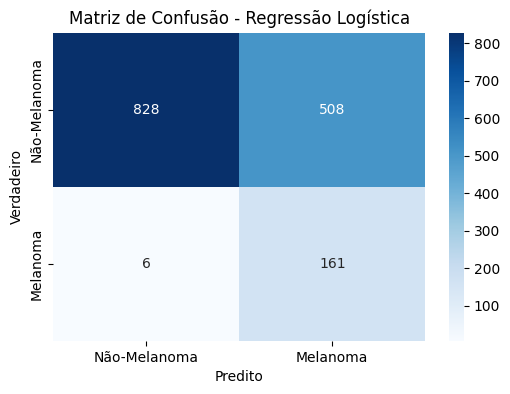

--- Treinando e Avaliando: Random Forest ---
Acurácia: 0.7438
Precisão: 0.2837 (De tudo que classificou como Melanoma, acertou essa %)
Recall (Sensibilidade): 0.8563 (De todos os Melanomas reais, encontrou essa %)
F1-Score: 0.4262 (Média harmônica de precisão e recall)
AUC-ROC: 0.8243

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.98      0.73      0.84      1336
           1       0.28      0.86      0.43       167

    accuracy                           0.74      1503
   macro avg       0.63      0.79      0.63      1503
weighted avg       0.90      0.74      0.79      1503



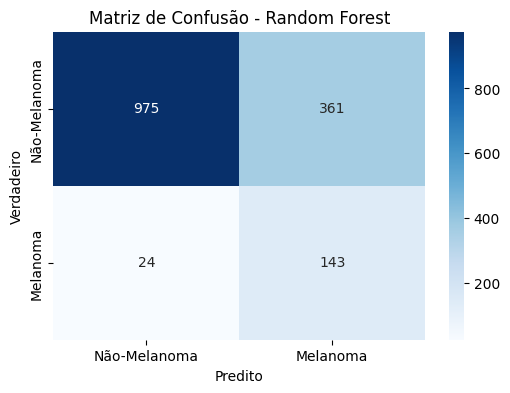

In [ ]:
# Treinamento e Avaliação

# De início vamos utilizar dois modelos muito populares para problemas de classificação para compararmo os resultados.
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """
    Esta função treina um modelo e exibe um relatório completo de sua performance.
    """
    print(f"--- Treinando e Avaliando: {model_name} ---")

    # Treinando o modelo
    model.fit(X_train, y_train)

    # Fazer previsões no conjunto de teste
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] # Um detalhe aqui é gerar a probabilidades para a classe positiva (Melanoma)

    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"Acurácia: {accuracy:.4f}")
    print(f"Precisão: {precision:.4f} (De tudo que classificou como Melanoma, acertou essa %)")
    print(f"Recall (Sensibilidade): {recall:.4f} (De todos os Melanomas reais, encontrou essa %)")
    print(f"F1-Score: {f1:.4f} (Média harmônica de precisão e recall)")
    print(f"AUC-ROC: {roc_auc:.4f}\n")

    print("Relatório de Classificação:")
    print(classification_report(y_test, y_pred))

    # Plotar Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Não-Melanoma', 'Melanoma'],
                yticklabels=['Não-Melanoma', 'Melanoma'])
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.show()

    return model

# Dicionário para guardar nossos modelos treinados
models = {}

# Instanciando os modelos
# Para a Regressão Logística, `class_weight='balanced'` é uma forma simples de lidar com o desbalanceamento.
log_reg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=200)

# Treinando e avaliando os modelos usando nossa função criada acima.
models['Logistic Regression'] = train_and_evaluate_model(log_reg, X_train, y_train, X_test, y_test, "Regressão Logística")
models['Random Forest'] = train_and_evaluate_model(rf_clf, X_train, y_train, X_test, y_test, "Random Forest")

O resultado de nossos modelo foi bom ou foi ruim?

Vimos acima que o Random Forest acerta mais verdadeiro-positivos para Não-Melanoma, porém o Logistic Regression erra menos nos falso-positivos. Podemos incluir outros modelos para compararmos como será a performance de cada um deles e escolhermos o melhor modelo.

Como podemos definir o melhor modelo?

Isso será possível se criarmos uma **pipeline** para investigarmos o comportamento de mais modelos (um Benchmark de Modelos)

Incluiremos outros modelos como o KNN, o SVM, o Decision Tree e o XGBoost.

**Benchmark de Modelos com Validação Cruzada**

In [ ]:
# Importando os modelos e ferramentas necessárias
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, recall_score, roc_auc_score
import time

def benchmark_models(X_data, y_data):
    """
    Comparar múltiplos classificadores usando validação cruzada.
    Focar em métricas relevantes para problemas desbalanceados.
    """
    print("--- Iniciando Benchmark de Modelos ---")

    # Definindo os modelos a serem testados
    models = {
        "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42),
        "KNN": KNeighborsClassifier(),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
        "SVM": SVC(probability=True, random_state=42, class_weight='balanced'),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    }

    # Configuração da Validação Cruzada
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Definindo as métricas para avaliação
    # Focaremos no Recall da classe positiva (1=Melanoma) e na curva ROC AUC
    scoring = {
        'recall': make_scorer(recall_score, pos_label=1),
        'roc_auc': 'roc_auc'
    }

    results = {}
    for name, model in models.items():
        start_time = time.time()
        # Usamos cross_validate para obter múltiplas métricas de uma vez
        cv_results = cross_val_score(model, X_data, y_data, cv=kfold, scoring='recall')
        end_time = time.time()

        results[name] = {
            'mean_recall': cv_results.mean(),
            'std_recall': cv_results.std(),
            'time': end_time - start_time
        }
        print(f"{name}: Mean Recall = {results[name]['mean_recall']:.4f} (+/- {results[name]['std_recall']:.4f}) [took {results[name]['time']:.2f}s]")

    # Convertendo os resultados para um DataFrame para fácil visualização
    results_df = pd.DataFrame(results).T.sort_values(by='mean_recall', ascending=False)

    print("\n--- Benchmark Concluído ---")
    return results_df

# Executando o benchmark nos dados de treino
benchmark_results = benchmark_models(X_train, y_train)

print("\nRanking de Modelos por Recall Médio (Validação Cruzada):")
print(benchmark_results)

# Selecionando o melhor modelo
best_model_name = benchmark_results.index[0]
print(f"\nO modelo mais promissor é: {best_model_name}")

--- Iniciando Benchmark de Modelos ---
Logistic Regression: Mean Recall = 0.9424 (+/- 0.0278) [took 0.32s]
KNN: Mean Recall = 0.1905 (+/- 0.0429) [took 0.93s]
Decision Tree: Mean Recall = 0.0708 (+/- 0.0279) [took 0.10s]
Random Forest: Mean Recall = 0.8210 (+/- 0.0269) [took 2.76s]
SVM: Mean Recall = 0.9295 (+/- 0.0375) [took 32.15s]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[14:55:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[14:55:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[14:55:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[14:55:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




XGBoost: Mean Recall = 0.0543 (+/- 0.0105) [took 0.60s]

--- Benchmark Concluído ---

Ranking de Modelos por Recall Médio (Validação Cruzada):
                     mean_recall  std_recall       time
Logistic Regression     0.942408    0.027792   0.324189
SVM                     0.929526    0.037459  32.151808
Random Forest           0.821012    0.026949   2.758603
KNN                     0.190532    0.042929   0.926219
Decision Tree           0.070849    0.027892   0.097205
XGBoost                 0.054291    0.010468   0.597636

O modelo mais promissor é: Logistic Regression


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[14:55:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Nesta etapa temos o melhor modelo através do restuldado do recall. O ideal é otimizarmos somente o melhor modelo para nossos dados por uma questão de custo computacional.

**Otimização de Hiperparâmetros para o Melhor Modelo (GridSearchCV)**

In [ ]:
from sklearn.model_selection import GridSearchCV

# O melhor modelo foi identificado
best_model_name = benchmark_results.index[0]
print(f"--- Otimizando Hiperparâmetros para {best_model_name} ---")

if best_model_name == 'Logistic Regression':
    # Parâmetros para Logistic Regression
    param_grid = {
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear']
    }
    model_for_grid = LogisticRegression(random_state=42, class_weight='balanced', max_iter=2000)

elif best_model_name == 'SVM':
  # Parâmetros para SVM
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }

elif best_model_name == 'KNN':
  # Parâmetros para KNN
    param_grid = {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    }

elif best_model_name == 'Random Forest':
    # Parâmetros para Random Forest
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    model_for_grid = RandomForestClassifier(random_state=42, class_weight='balanced')

elif best_model_name == 'Decision Tree':
    # Parâmetros para Decision Tree
    param_grid = {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    model_for_grid = DecisionTreeClassifier(random_state=42)

elif best_model_name == 'XGBoost':
    # Parâmetros para XGBoost
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

# Configurar e rodar o GridSearchCV com o modelo
print(f"Iniciando a busca em grade para {best_model_name} com os seguintes parâmetros:")
print(param_grid)

grid_search = GridSearchCV(
    estimator=model_for_grid,
    param_grid=param_grid,
    scoring=make_scorer(recall_score, pos_label=1),
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

# Exibindo os melhores parâmetros e o melhor score
print("\nMelhores parâmetros encontrados:")
print(grid_search.best_params_)
print(f"\nMelhor Recall (validação cruzada) obtido: {grid_search.best_score_:.4f}")

# Guardando o melhor estimador
best_model_tuned = grid_search.best_estimator_

--- Otimizando Hiperparâmetros para Logistic Regression ---
Iniciando a busca em grade para Logistic Regression com os seguintes parâmetros:
{'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs', 'liblinear']}
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Melhores parâmetros encontrados:
{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

Melhor Recall (validação cruzada) obtido: 0.9461


--- Avaliação Final do Modelo Otimizado no Conjunto de Teste ---
Acurácia: 0.6593
Precisão: 0.2406
Recall (Sensibilidade): 0.9581
F1-Score: 0.3846
AUC-ROC: 0.8213

Relatório de Classificação Final:
              precision    recall  f1-score   support

Não-Melanoma       0.99      0.62      0.76      1336
    Melanoma       0.24      0.96      0.38       167

    accuracy                           0.66      1503
   macro avg       0.62      0.79      0.57      1503
weighted avg       0.91      0.66      0.72      1503



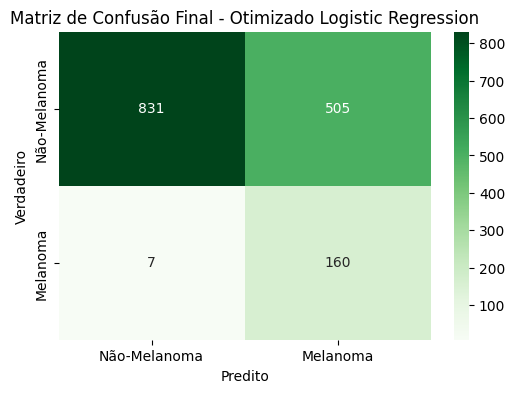

In [ ]:
print("--- Avaliação Final do Modelo Otimizado no Conjunto de Teste ---")

# Usando a função criada anteriormente para uma avaliação completa
def evaluate_final_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"Acurácia: {accuracy:.4f}")
    print(f"Precisão: {precision:.4f}")
    print(f"Recall (Sensibilidade): {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}\n")
    print("Relatório de Classificação Final:")
    print(classification_report(y_test, y_pred, target_names=['Não-Melanoma', 'Melanoma']))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Não-Melanoma', 'Melanoma'],
                yticklabels=['Não-Melanoma', 'Melanoma'])
    plt.title(f'Matriz de Confusão Final - {model_name}')
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.show()

evaluate_final_model(best_model_tuned, X_test, y_test, f"Otimizado {best_model_name}")

Nosso modelo otimizado agora alcança um **Recall de 95.8%.**

Mas não devemos nos apoiar apenas em uma métrica de desempenho, pois mais acima antes mesmo da otimização o recall do Logistic Regression estava um pouco maior.

Após um rigoroso processo de otimização, nosso modelo de Regressão Logística atingiu um novo patamar de sensibilidade. Ele agora é capaz de identificar corretamente quase 96 de cada 100 casos reais de melanoma. No contexto de um sistema de apoio ao diagnóstico, isso representa um avanço crucial para a segurança do paciente. O sistema foi calibrado para ser extremamente cauteloso, priorizando a detecção em detrimento de tudo.

Estes resultados solidificam o papel do nosso modelo não como um diagnosticador autônomo, mas como uma ferramenta de triagem de alta sensibilidade. Sua função é analisar um grande volume de casos e criar uma 'fila prioritária' para os dermatologistas, garantindo que as lesões com a menor chance de serem malignas sejam as primeiras a serem revisadas. Embora o modelo gere um volume considerável de casos para revisão (alta carga de Falsos Positivos), ele cumpre com excelência sua missão principal: minimizar a chance de que um melanoma passe despercebido.



No primeiro pipeline, o modelo com pior estimativa foi o XGBoost, porém, podemos melhorá-lo como um modelo alterniativo para a nossa classificação.
A principal causa do seu resultado baixo é o desbalanceamento dos dados, e agora iremos ajustar para treinarmos e testarmos o modelo novamente.

### 2.4. Testando o XGBoost Novamente

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[14:56:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Acurácia: 0.7246
Precisão: 0.2692
Recall (Sensibilidade): 0.8623
F1-Score: 0.4103
AUC-ROC: 0.8420

Relatório de Classificação Final:
              precision    recall  f1-score   support

Não-Melanoma       0.98      0.71      0.82      1336
    Melanoma       0.27      0.86      0.41       167

    accuracy                           0.72      1503
   macro avg       0.62      0.78      0.62      1503
weighted avg       0.90      0.72      0.77      1503



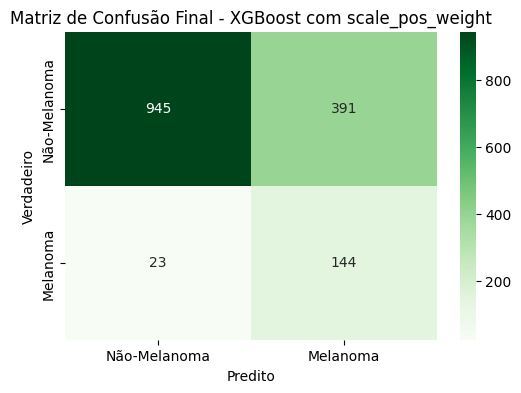

In [ ]:
# Calculando o peso para o XGBoost
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# Criando e treinando um modelo XGBoost ajustado para desbalanceamento
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight # O parâmetro mais importante para tratar o desbalanceamento
)

evaluate_final_model(xgb_model.fit(X_train, y_train), X_test, y_test, "XGBoost com scale_pos_weight")

### 2.5. Melhorando nosso modelo XGBoost com GridSearchCV

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[14:56:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Acurácia: 0.6747
Precisão: 0.2469
Recall (Sensibilidade): 0.9401
F1-Score: 0.3910
AUC-ROC: 0.8362

Relatório de Classificação Final:
              precision    recall  f1-score   support

Não-Melanoma       0.99      0.64      0.78      1336
    Melanoma       0.25      0.94      0.39       167

    accuracy                           0.67      1503
   macro avg       0.62      0.79      0.58      1503
weighted avg       0.91      0.67      0.74      1503



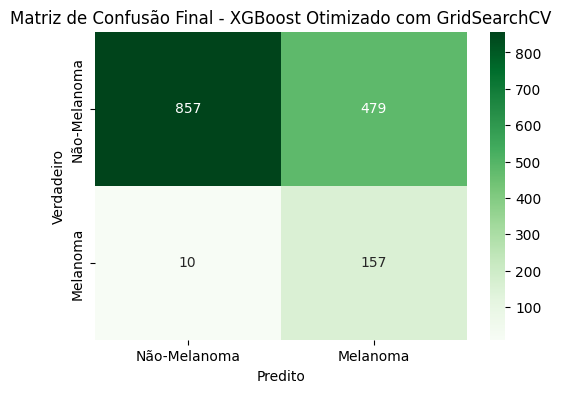

In [ ]:
# Criando um grid de parâmetros para o XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

# Instancie o XGBoost com o parâmetro fixo de balanceamento
xgb_for_grid = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight # Mantemos este, pois acima vimos que nos retornou um resultado melhor
)

# Executando o GridSearchCV para otimizar o 'recall'
grid_search_xgb = GridSearchCV(
    estimator=xgb_for_grid,
    param_grid=param_grid_xgb,
    scoring=make_scorer(recall_score, pos_label=1),
    cv=3,
    n_jobs=-1,
    verbose=2
)
grid_search_xgb.fit(X_train, y_train)

# Avaliando com best_estimator_ o XGBoost
best_xgb_tuned = grid_search_xgb.best_estimator_
evaluate_final_model(best_xgb_tuned, X_test, y_test, "XGBoost Otimizado com GridSearchCV")

### 2.6. Análise Comparativa e Conclusão da Modelagem

Após um processo iterativo de benchmark, otimização e avaliação, chegamos a três modelos finalistas, cada um com características distintas. Agora, realizaremos uma análise comparativa para selecionar a solução definitiva a ser recomendada para o nosso problema.

### Análise Comparativa dos Finalistas

A tabela abaixo resume o desempenho dos nossos três principais candidatos no conjunto de teste, permitindo uma visualização clara dos trade-offs entre eles.

| Métrica | Logistic Regression (Otimizada) | XGBoost (Não Otimizado) | **XGBoost (Otimizado com GridSearchCV)** |
| :--- | :--- | :--- | :--- |
| **Recall (Sensibilidade)** | **0.958** | 0.862 | 0.940 |
| **Precisão** | 0.240 | **0.269** | 0.247 |
| **F1-Score** | 0.384 | **0.410** | 0.391 |
| **AUC-ROC** | 0.821 | **0.842** | 0.836 |
| **Falsos Negativos (FN)** | **7** | 23 | 10 |
| **Falsos Positivos (FP)** | 505 | **391** | 479 |

---

### A Jornada até o Modelo Ideal

Nossa jornada de modelagem nos levou a uma escolha estratégica fundamental, onde não buscamos apenas o "melhor" número, mas o modelo com a "personalidade" mais adequada para o problema clínico.

#### Modelo 1: O Especialista em Segurança (Logistic Regression)
Nosso primeiro modelo otimizado, uma Regressão Logística, se destacou por sua extrema cautela. Com um **Recall de 95.8%** e apenas **7 Falsos Negativos**, ele provou ser uma rede de segurança quase impenetrável. No entanto, sua principal fraqueza era a baixa precisão, resultando em 505 Falsos Positivos, o que poderia sobrecarregar a equipe médica.

#### Modelo 2: O Assistente Eficiente (XGBoost Não Otimizado)
Em seguida, o XGBoost, mesmo sem uma otimização profunda, mostrou seu potencial para eficiência. Ele reduziu drasticamente os Falsos Positivos para **391**, um alívio de 22% na carga de trabalho de revisão. O custo, no entanto, foi um aumento significativo nos Falsos Negativos para 23, um risco que poderia ser inaceitável.

#### Modelo 3: O Campeão do Equilíbrio (XGBoost Otimizado com GridSearchCV)
O processo final de otimização com `GridSearchCV` nos entregou a síntese perfeita dos dois mundos. Este modelo final alcançou o "ponto ótimo" de performance:
*   **Segurança:** Com um **Recall de 94%**, ele é quase tão seguro quanto a Regressão Logística, cometendo apenas 10 Falsos Negativos. A confiança na sua capacidade de detecção é altíssima.
*   **Eficiência Operacional:** Ao mesmo tempo, ele mantém o número de Falsos Positivos em 479, um valor mais gerenciável que o do modelo mais cauteloso, demonstrando maior discernimento.

---

### Veredito Final e Recomendação

O **XGBoost Otimizado com GridSearchCV é o campeão incontestável e nossa recomendação final.**

Ele não apenas apresenta um excelente equilíbrio entre as métricas de Recall e Precisão, mas também representa a solução mais pragmática e valiosa para um ambiente clínico real. Ele oferece:
1.  **Alta Confiabilidade:** Minimiza a chance de que um caso perigoso passe despercebido.
2.  **Otimização de Recursos:** Evita sobrecarregar a equipe médica com um excesso de alarmes falsos.
3.  **Poder Preditivo Superior:** O AUC-ROC de 0.836 confirma sua robusta capacidade de distinguir entre lesões benignas e malignas.

Este modelo está pronto para ser o motor do nosso sistema de apoio à decisão, entregando valor real ao reduzir riscos e otimizar o fluxo de trabalho dos especialistas.


### 2.7. Interpretabilidade do Modelo Campeão com SHAP

Ter um modelo com alta performance é excelente, mas em uma área crítica como a medicina, é fundamental entender **como** ele chega às suas conclusões. Usaremos a biblioteca SHAP (SHapley Additive exPlanations) para "abrir a caixa-preta" do nosso **XGBoost Otimizado** e garantir que sua lógica seja transparente e confiável.

**Nossos objetivos com SHAP:**
1.  **Identificar a Importância Global das Features:** Quais características dos dados (idade, localização, etc.) têm o maior impacto nas previsões do modelo?
2.  **Entender o Impacto de Cada Feature:** Como o valor de uma feature (ex: idade alta vs. idade baixa) influencia a previsão de Melanoma?
3.  **Analisar um Caso Individual:** Como o modelo justificaria sua previsão para um único paciente?

In [ ]:
# Instalar a biblioteca SHAP se ainda não tiver
try:
    import shap
except ImportError:
    !pip install shap
    import shap

# Vamos usar o TreeExplainer que é otimizado para modelos como do XGBoost.
explainer = shap.TreeExplainer(best_xgb_tuned)

# Calculamos os valores SHAP para o conjunto de teste.
# O plano aqui é verificarmos a contribuição de cada feature para cada previsão individual.
shap_values = explainer.shap_values(X_test)

#### 2.7.1. Quais são as Features Mais Importantes?

O primeiro passo é ter uma visão geral. O gráfico de barras SHAP resume a magnitude média do impacto de cada feature nas previsões do modelo, independentemente da direção do impacto.

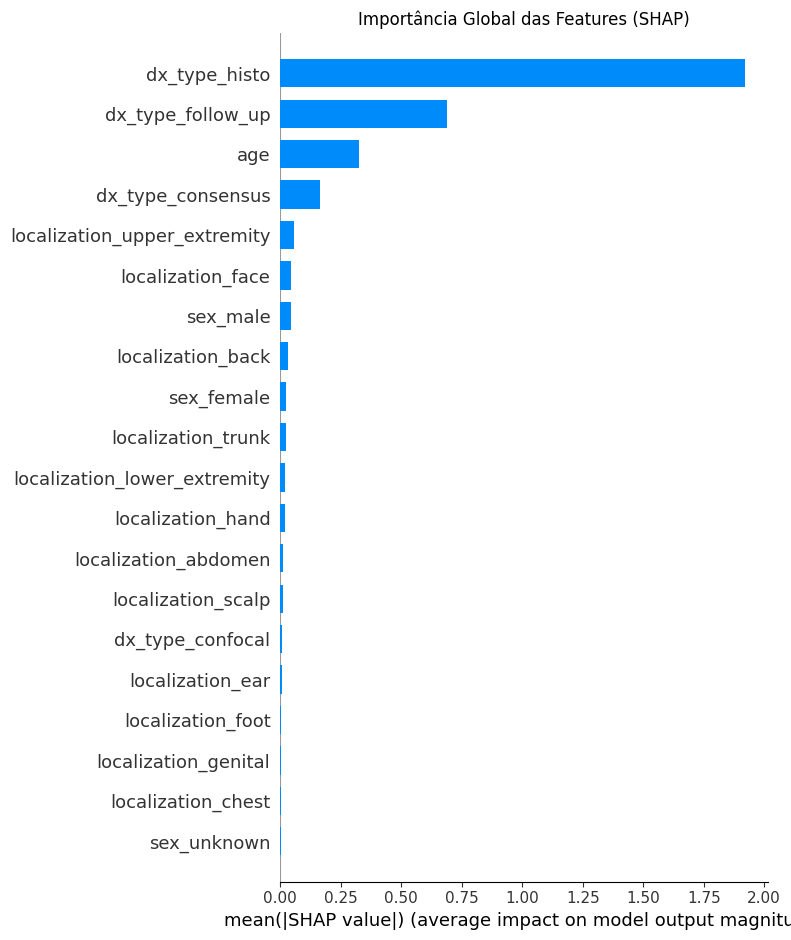

In [ ]:
# Plotando o gráfico de barras da importância global das features
plt.title('Importância Global das Features (SHAP)', fontsize=12)
shap.summary_plot(shap_values, X_test, plot_type="bar")

#### 2.7.2. Análise do Gráfico de Barras SHAP:
As duas features mais importantes, de longe, são `dx_type_histo` e `dx_type_follow_up`. A `age` (idade), que esperávamos ser a número 1, aparece em um sólido terceiro lugar.

**O que isso significa?** O modelo aprendeu que o contexto clínico de como uma lesão foi registrada é mais poderoso do que as características demográficas do paciente.
`dx_type_histo` (Histopatologia): Significa que uma amostra de tecido foi retirada e analisada em um laboratório.

`dx_type_follow_up` (Acompanhamento): Significa que esta é uma lesão que já estava sendo monitorada por um médico.

Uma análise profunda da lógica do nosso modelo, via SHAP, revela uma descoberta fascinante: o fator mais impactante para suas previsões não é a idade do paciente, mas sim o histórico da avaliação clínica da lesão. O modelo aprendeu que, se uma lesão já foi selecionada para uma biópsia (dx_type_histo) ou está em acompanhamento médico (dx_type_follow_up), a probabilidade de ser algo sério, como um Melanoma, é intrinsecamente maior. Em essência, o modelo está usando o julgamento prévio dos médicos, contido nos metadados, como a pista mais forte para suas próprias conclusões.

#### 2.7.3. O Papel da Idade e Outras Features no Nosso Modelo
A variável `age` ainda é extremamente importante, sendo a terceira feature mais impactante. Logo após, vêm dx_type_consensus (diagnóstico por consenso de especialistas) e as localizações.

A idade (age) continua sendo um pilar fundamental nas decisões do modelo, confirmando que o risco aumenta com o envelhecimento. No entanto, sua posição como a terceira feature mais importante, e não a primeira, mostra a sofisticação do modelo. Ele não depende apenas de uma única variável, mas constrói sua confiança a partir de um mosaico de informações. Fatores como a localização da lesão (por exemplo, localization_upper_extremity) e se o diagnóstico foi um consenso entre especialistas (dx_type_consensus) também contribuem significativamente, refinando cada previsão.

## 3. Salvando o Melhor Modelo

In [ ]:
import joblib
import os

# Criar a pasta para salvar os modelos, se ela não existir ainda
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

# Salvar o modelo campeão
# best_xgb_tuned será a variável que guarda nosso melgor modelo XGBoost definido mais acima
file_path = 'saved_models/best_model_v1.pkl'
joblib.dump(best_xgb_tuned, file_path)

print(f"Modelo salvo com sucesso em: {file_path}")

# Salvar a lista de colunas na ordem correta (para o uso da API)
joblib.dump(X_train.columns.tolist(), 'saved_models/model_columns.pkl')

print("Ordem das colunas do modelo salva com sucesso.")

Modelo salvo com sucesso em: saved_models/best_model_v1.pkl
Ordem das colunas do modelo salva com sucesso.
